Generate a PNG of binned (0.1 m/z) raw data for a single frame

In [41]:
import sqlite3
import pandas as pd
import numpy as np
import sys

In [42]:
RT_LIMIT_LOWER = 4340
RT_LIMIT_UPPER = 4580

In [43]:
MS1_CE = 10

In [44]:
# BASE_NAME = "/home/ubuntu/HeLa_20KInt-rt-{}-{}".format(RT_LIMIT_LOWER,RT_LIMIT_UPPER)
BASE_NAME = "/Users/darylwilding-mcbride/Downloads/HeLa_20KInt-rt-{}-{}".format(RT_LIMIT_LOWER,RT_LIMIT_UPPER)
CONVERTED_DATABASE_NAME = '{}/HeLa_20KInt.sqlite'.format(BASE_NAME)
# ALLPEPTIDES_FILENAME = '/home/ubuntu/maxquant_results/txt/allPeptides.txt'
ALLPEPTIDES_FILENAME = '/Users/darylwilding-mcbride/Downloads/maxquant_results/txt/allPeptides.txt'

In [45]:
CONVERTED_DATABASE_NAME

'/Users/darylwilding-mcbride/Downloads/HeLa_20KInt-rt-4340-4580/HeLa_20KInt.sqlite'

In [46]:
db_conn = sqlite3.connect(CONVERTED_DATABASE_NAME)
df = pd.read_sql_query("select frame_id,retention_time_secs from frame_properties where retention_time_secs >= {} and retention_time_secs <= {} and collision_energy == {}".format(RT_LIMIT_LOWER,RT_LIMIT_UPPER,MS1_CE), db_conn)
db_conn.close()

In [47]:
df.head()

,frame_id,retention_time_secs
0,40411,4340.340330
1,40422,4341.521415
2,40433,4342.702923
3,40444,4343.883324
4,40455,4345.067491


In [69]:
RAW_FRAME_ID = 40444
RAW_FRAME_RT = df[df.frame_id == RAW_FRAME_ID].retention_time_secs.values[0]

In [49]:
MZ_MIN = 100.0
MZ_MAX = 1700.0
MZ_BIN_WIDTH = 0.1
MZ_BINS = int((MZ_MAX-MZ_MIN)/MZ_BIN_WIDTH)
SCAN_MIN = 1
SCAN_MAX = 910

In [50]:
MZ_BINS

16000

In [51]:
height = SCAN_MAX
width = MZ_BINS

In [52]:
im_array = np.zeros([height, width, 3], dtype=np.uint8)  # container for the image

Populate the image array with points from the raw frame

In [53]:
# load the raw frame points
db_conn = sqlite3.connect(CONVERTED_DATABASE_NAME)
raw_points_df = pd.read_sql_query("select mz,scan,intensity from frames where frame_id == {}".format(RAW_FRAME_ID), db_conn)
db_conn.close()

In [54]:
raw_points_df.intensity.max()

11145

In [55]:
len(raw_points_df)

256539

In [56]:
intensity_array = np.zeros([height, width], dtype=np.uint16)  # scratchpad for the intensity value prior to image conversion
for point_idx in range(len(raw_points_df)):
    point_df = raw_points_df.iloc[point_idx]
    mz = point_df.mz
    scan = int(point_df.scan)
    if (mz >= MZ_MIN) and (mz <= MZ_MAX) and (scan >= SCAN_MIN) and (scan <= SCAN_MAX):
        mz_array_idx = int((mz-MZ_MIN)/MZ_BIN_WIDTH)+1
        scan_array_idx = scan
        intensity = int(point_df.intensity)
        intensity_array[scan_array_idx,mz_array_idx] += intensity

In [57]:
intensity_array.max()

13171

In [58]:
DELTA_MZ = 1.003355     # Mass difference between Carbon-12 and Carbon-13 isotopes, in Da. For calculating the spacing between isotopic peaks.

In [59]:
MZ_TOLERANCE_PPM = 5
MZ_TOLERANCE_PERCENT = MZ_TOLERANCE_PPM * 10**-4

In [60]:
round(2.3456788,1)

2.3

In [61]:
import decimal

In [62]:
abs(decimal.Decimal("{}".format(MZ_BIN_WIDTH)).as_tuple().exponent)

1

In [63]:
MZ_BIN_WIDTH

0.1

there are 1001 MQ features overlapping this frame


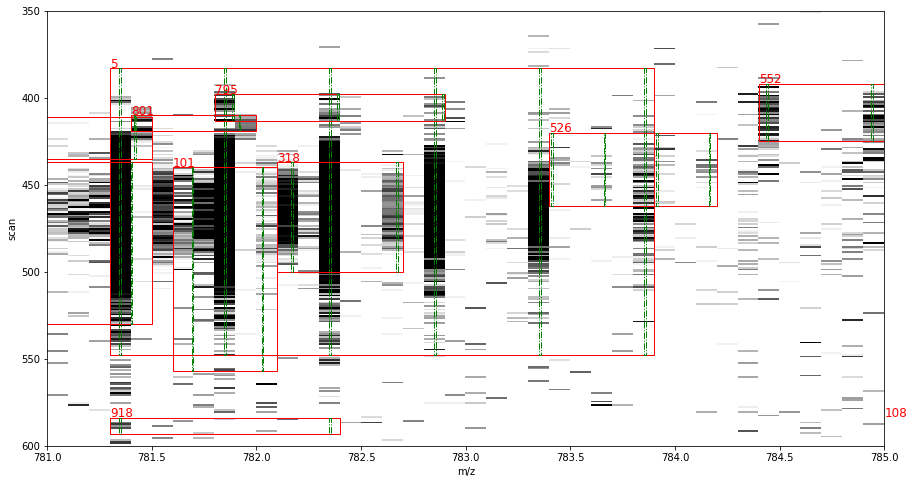

In [130]:
# overlay the image with MQ feature locations
import matplotlib.patches as patches
from matplotlib import colors, cm, pyplot as plt

mz_actual_lower = 781
mz_actual_upper = 785

mz_idx_lower = int((mz_actual_lower-MZ_MIN)/MZ_BIN_WIDTH)+1
mz_idx_upper = int((mz_actual_upper-MZ_MIN)/MZ_BIN_WIDTH)+1

scan_lower = 350
scan_upper = 600

f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)
plt.xlabel('m/z')
plt.ylabel('scan')
plt.margins(0.06)

allpeptides_df = pd.read_csv(ALLPEPTIDES_FILENAME, sep='\t')
allpeptides_df.rename(columns={'Number of isotopic peaks':'isotope_count', 'm/z':'mz', 'Number of data points':'number_data_points', 'Intensity':'intensity', 'Ion mobility index':'scan', 'Ion mobility index length':'scan_length', 'Ion mobility index length (FWHM)':'scan_length_fwhm', 'Retention time':'rt', 'Retention length':'rt_length', 'Retention length (FWHM)':'rt_length_fwhm', 'Charge':'charge_state', 'Number of pasef MS/MS':'number_pasef_ms2_ids', 'Isotope correlation':'isotope_correlation'}, inplace=True)
allpeptides_df["rt_delta"] = allpeptides_df.rt_length/2
allpeptides_df["rt_lower"] = allpeptides_df.rt - allpeptides_df.rt_delta
allpeptides_df["rt_upper"] = allpeptides_df.rt + allpeptides_df.rt_delta

# allpeptides_subset_df = allpeptides_df[(allpeptides_df.intensity.notnull()) & (allpeptides_df.rt_lower <= RAW_FRAME_RT) & (allpeptides_df.rt_upper >= RAW_FRAME_RT) & (allpeptides_df.number_pasef_ms2_ids > 0)].copy()
allpeptides_subset_df = allpeptides_df[(allpeptides_df.intensity.notnull()) & (allpeptides_df.rt_lower <= RAW_FRAME_RT) & (allpeptides_df.rt_upper >= RAW_FRAME_RT)].copy()
print("there are {} MQ features overlapping this frame".format(len(allpeptides_subset_df)))
allpeptides_subset_df.sort_values(by=['intensity'], ascending=False, inplace=True)
allpeptides_subset_df["mq_feature_id"] = np.arange(start=1, stop=len(allpeptides_subset_df)+1)

f.set_figheight(8)
f.set_figwidth(15)

# show the image
cmap = cm.get_cmap('gist_yarg')
cmap_value_lower = 1
cmap_value_upper = 150
ax1.imshow(intensity_array[scan_lower:scan_upper,mz_idx_lower:mz_idx_upper], cmap=cmap, norm=colors.Normalize(vmin=cmap_value_lower, vmax=cmap_value_upper, clip=True), interpolation='none', aspect='auto', extent=[mz_actual_lower,mz_actual_upper,scan_upper,scan_lower])

# overlay the MQ feature rectangles
for mq_feature_idx in range(len(allpeptides_subset_df)):
    mq_feature_df = allpeptides_subset_df.iloc[mq_feature_idx]
    mq_feature_id = int(mq_feature_df.mq_feature_id)

    charge_state = int(mq_feature_df.charge_state)
    isotope_count = int(mq_feature_df.isotope_count)

    expected_isotope_spacing_mz = DELTA_MZ / charge_state

    # determine the bounding box coordinates for m/z and scan in real space
    mq_feature_mz = mq_feature_df.mz
    mz_delta = mq_feature_mz * MZ_TOLERANCE_PERCENT / 100
    rect_mz_lower = int(mq_feature_mz / MZ_BIN_WIDTH) * MZ_BIN_WIDTH
    rect_mz_upper = int((mq_feature_mz + ((isotope_count-1) * expected_isotope_spacing_mz)) / MZ_BIN_WIDTH) * MZ_BIN_WIDTH + MZ_BIN_WIDTH
    rect_mz_range = rect_mz_upper - rect_mz_lower

    rect_scan = mq_feature_df.scan
    rect_scan_delta = int(mq_feature_df.scan_length / 2)
    rect_scan_lower = rect_scan - rect_scan_delta
    rect_scan_upper = rect_scan + rect_scan_delta
    rect_scan_range = int(mq_feature_df.scan_length)
    
    # draw the rectangle for the feature's extent
    mq_feature_rect = patches.Rectangle((rect_mz_lower,rect_scan_lower),rect_mz_range,rect_scan_range,linewidth=1,linestyle='-',edgecolor='r',facecolor='none', label='feature')
    ax1.add_patch(mq_feature_rect)

    # draw the isotopes
    isotope_base_mz_lower = mq_feature_mz - mz_delta
    isotope_base_mz_upper = mq_feature_mz + mz_delta
    for isotope_idx in range(0,isotope_count):
        isotope_mz_lower = isotope_base_mz_lower + (isotope_idx * expected_isotope_spacing_mz)
        isotope_mz_upper = isotope_base_mz_upper + (isotope_idx * expected_isotope_spacing_mz)
        isotope_rect = patches.Rectangle((isotope_mz_lower,rect_scan_lower),isotope_mz_upper-isotope_mz_lower,rect_scan_range,linewidth=1,linestyle='-.',edgecolor='g',facecolor='none', label='isotope')
        ax1.add_patch(isotope_rect)
    
    # draw the feature label
    text_style = dict(size=12, color='red')
    text_x = rect_mz_lower
    text_y = rect_scan_lower-0.5
    if (text_x >= mz_actual_lower) and (text_x <= mz_actual_upper) and (text_y >= scan_lower) and (text_y <= scan_upper):
        ax1.text(text_x, text_y, "{}".format(mq_feature_id), **text_style)

plt.show()

In [127]:
feature_df = allpeptides_subset_df[allpeptides_subset_df.mq_feature_id==918].iloc[0]
feature_df

Raw file                HeLa_20KInt_2KIT_Slot1-46_01_1179
charge_state                                            1
mz                                                781.349
Mass                                              780.342
Resolution                                        22745.8
number_data_points                                    196
Number of frames                                       12
isotope_count                                           2
isotope_correlation                              0.976089
Mass fractional part                             0.342031
Mass deficit                                   -0.0569263
rt                                                4339.16
rt_length                                          12.989
rt_length_fwhm                                      4.718
Min frame index                                      3667
Max frame index                                      3678
scan                                                  588
scan_length   